# **TDP Final Project** - Wavelets:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from sdas.tests.LoadSdasData import LoadSdasData
from sdas.tests.StartSdas import StartSdas

import pywt

plt.style.use('bmh')

In [4]:
# Load and select data
shot = 35057
client = StartSdas()

d={} # Empty dictionary: Reading data for all 'good' coils.
for x in range(2,13): # For looping 
    if(x<10):
        d["Coil{0}".format(x)]= LoadSdasData(client, "PCIE_ATCA_ADC_16.BOARD_2.CHANNEL_00{0}".format(x), shot)
    elif(x!=11):
        d["Coil{0}".format(x)]= LoadSdasData(client, "PCIE_ATCA_ADC_16.BOARD_2.CHANNEL_0{0}".format(x), shot)

# d['Coil{x}'][0] -> '$dB_{\theta}/dt$ (a.u.)'
# d['Coil{x}'][1] -> Time

In [5]:
fs = float(1/(d['Coil2'][1][1] - d['Coil2'][1][0])*1e6)
NFFT = 2048 # Number of points used in FFT calculation.
Delta_t = 1/fs
Delta_T = NFFT * Delta_t
Delta_f = 1/Delta_T

print(f' NFFT = {NFFT}, fs = {fs}, Delta_t = {Delta_t} s, Delta_T = {Delta_T} s, Delta_f = {Delta_f} Hz.')

 NFFT = 2048, fs = 2000000.0, Delta_t = 5e-07 s, Delta_T = 0.001024 s, Delta_f = 976.5625 Hz.


(1025, 312) (1025,) (312,)


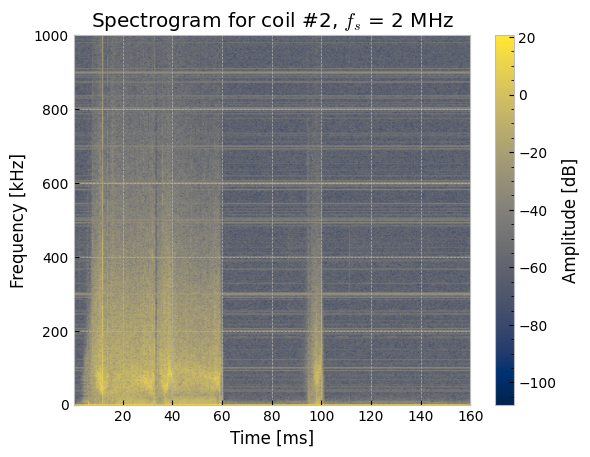

In [147]:
# Setup figures

# This property is related to the Heisenberg uncertainty principle, but not directly – see Gabor limit for discussion.
# The product of the standard deviation in time and frequency is limited. The boundary of the uncertainty principle 
# (best simultaneous resolution of both) is reached with a Gaussian window function (or mask function), as the Gaussian
#  minimizes the Fourier uncertainty principle. This is called the Gabor transform (and with modifications for multiresolution 
# becomes the Morlet wavelet transform).

fig, ax1 = plt.subplots()

Pxx, freqs, bins, im = plt.specgram(d['Coil2'][0], NFFT=NFFT, Fs=fs, noverlap=int (NFFT/2), cmap='cividis')
# This uses STFT: Short-Time Fourier Transform.

# Debugging:
print(Pxx.shape, freqs.shape, bins.shape)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.title(r'Spectrogram for coil #2, $f_{s}$' + f' = {fs * 1e-6:.0f} MHz')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [ms]')

scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

scale_x = 1e-3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.xaxis.set_major_formatter(ticks_x)

# plt.axis((45e-3, 50e-3, 0, 200e3)) # Chosen interval!
# plt.savefig('Coil2_Spectrogram.svg', format = 'svg')
plt.show()

In [148]:
t = d['Coil2'][1]*1e-6
sig  = d['Coil2'][0]

widths = []
for i in range(1,8):
    widths.append(2**i)
widths = np.arange(2, 50) # Just testing stuff.
print(f'Widths = {widths}.')

sampling_period = t[1] - t[0]

Widths = [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49].


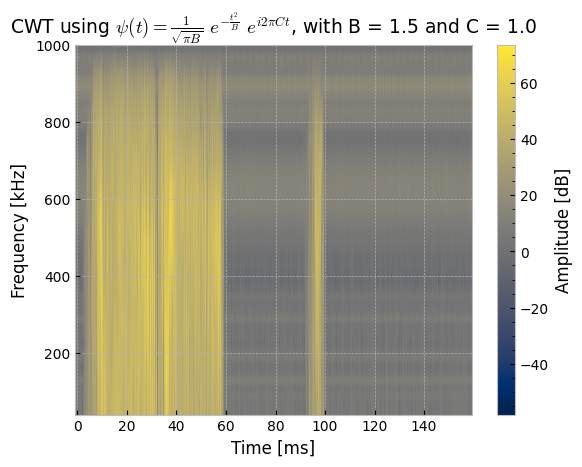

In [149]:
cwtmatr, freqs = pywt.cwt(sig, widths, 'cmor1.5-1.0', sampling_period)
power = (abs(cwtmatr)) ** 2

result = np.where(power > 0.0000000001, power, -10)
power = 10*np.log10(result, out=result, where=result > 0)

im = plt.imshow(power, cmap='cividis', aspect='auto',
                vmax=power.max(), vmin=power.min(),
                extent = [t[0]*1e3, t[-1]*1e3, freqs[-1]*1e-3, freqs[0]*1e-3], interpolation = None)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.title(r'CWT using $\psi(t) = \frac{1}{\sqrt{\pi B}}$ $e^{-\frac{t^2}{B}}$ $e^{i2\pi Ct}$, with B = 1.5 and C = 1.0', fontsize=13.5)
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [kHz]')

plt.show() # This is sort of similar to what we got before (using the STFT)!

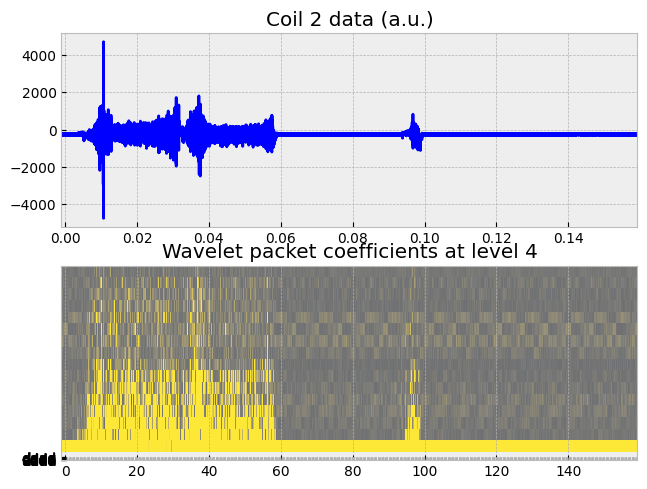

In [157]:
import matplotlib.cm as cm
import pylab

import pywt

wavelet = 'db2'
level = 4
order = "freq"  # "normal"
interpolation = 'nearest'

wp = pywt.WaveletPacket(sig, wavelet, 'sym', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = pylab.array([n.data for n in nodes], 'd')
values = abs(values)

f = pylab.figure()
f.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
pylab.subplot(2, 1, 1)
pylab.title("Coil 2 data (a.u.)")
pylab.plot(t, sig, 'b')
pylab.xlim(t[0], t[-1])

ax = pylab.subplot(2, 1, 2)
pylab.title("Wavelet packet coefficients at level %d" % level)
pylab.imshow(values, interpolation=interpolation, cmap='cividis', aspect="auto",
    origin="lower", extent = [t[0]*1e3, t[-1]*1e3, freqs[-1]*1e-3, freqs[0]*1e-3],
    vmax=power.max(), vmin=power.min())
pylab.yticks(pylab.arange(0.5, len(labels) + 0.5), labels)
# pylab.setp(ax.get_xticklabels(), visible=False)

pylab.show()

In [2]:
from scipy.io import readsav

In [3]:
data_dict = readsav('save_85925_H305.sav')
print(data_dict)

{'h305': array([-0.00427246,  0.00061035,  0.00183106, ..., -0.03448489,
        0.05554203,  0.00823975], dtype=float32), 't_h305': array([41.3     , 41.300003, 41.300003, ..., 44.699997, 44.7     ,
       44.7     ], dtype=float32)}


In [4]:
data = data_dict['h305']
time = data_dict['t_h305']

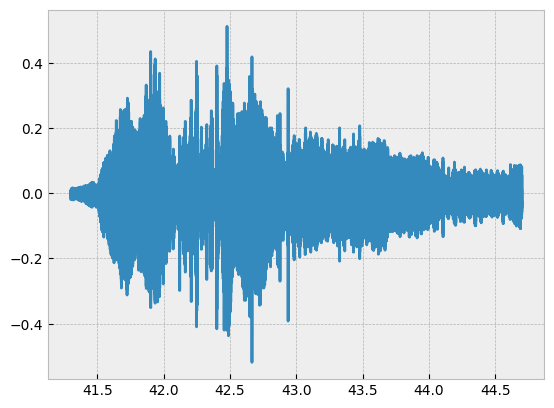

In [5]:
plt.plot(time, data)

In [18]:
t = time
sig  = data

widths = []
for i in range(1,10):
    widths.append(2**i)
widths = np.arange(0.5, 20) # Just testing stuff.
print(f'Widths = {widths}.')

dt = t[1] - t[0]
print(1/dt/2)
pywt.scale2frequency('mexh', widths)/dt

Widths = [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5].
131072.0


array([131072.        ,  43690.66666667,  26214.4       ,  18724.57142857,
        14563.55555556,  11915.63636364,  10082.46153846,   8738.13333333,
         7710.11764706,   6898.52631579,   6241.52380952,   5698.7826087 ,
         5242.88      ,   4854.51851852,   4519.72413793,   4228.12903226,
         3971.87878788,   3744.91428571,   3542.48648649,   3360.82051282])

Widths = [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5].


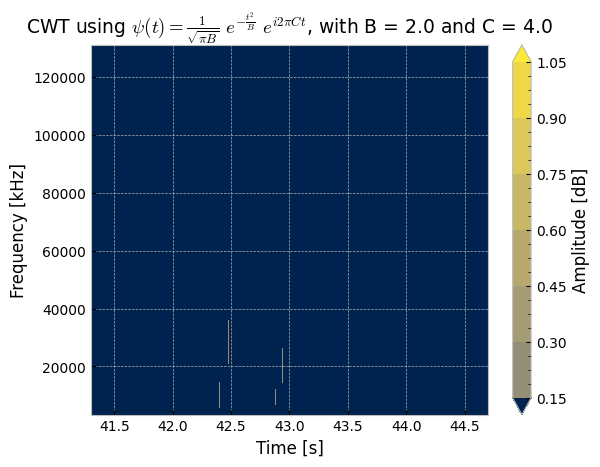

In [19]:
t = time
sig  = data

widths = []
for i in range(1,10):
    widths.append(2**i)
widths = np.arange(0.5, 20) # Just testing stuff.
print(f'Widths = {widths}.')

sampling_period = t[1] - t[0]


cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh', sampling_period)
power = (abs(cwtmatr)) ** 2

# result = np.where(power > 0.0000000001, power, -10)
# power = 10*np.log10(result, out=result, where=result > 0)

# im = plt.imshow(power, cmap='cividis', aspect='auto',
#                 vmax=power.max(), vmin=power.min(),
#                 extent = [t[0], t[-1], freqs[-1]*1e-3, freqs[0]*1e-3], interpolation = None)

im = plt.contourf(t, freqs, power, extend='both',cmap='cividis',
                  vmax=power.max(), vmin=-power.max(),
                  extent = [t[0], t[-1], freqs[0], freqs[-1]], origin = 'lower')

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.title(r'CWT using $\psi(t) = \frac{1}{\sqrt{\pi B}}$ $e^{-\frac{t^2}{B}}$ $e^{i2\pi Ct}$, with B = 2.0 and C = 4.0', fontsize=13.5)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')

plt.show() # This is sort of similar to what we got before (using the STFT)!

In [35]:
wavlist = pywt.wavelist(kind='continuous')
print(wavlist)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [38]:
print(cwtmatr.shape)

(58, 3400000)


In [17]:
fs = float(1/(time[1] - time[0]))
NFFT = 2048 # Number of points used in FFT calculation.
Delta_t = 1/fs
Delta_T = NFFT * Delta_t
Delta_f = 1/Delta_T

print(f' NFFT = {NFFT}, fs = {fs}, Delta_t = {Delta_t} s, Delta_T = {Delta_T} s, Delta_f = {Delta_f} Hz.')

NameError: name 'time' is not defined

(1025, 3319) (1025,) (3319,)


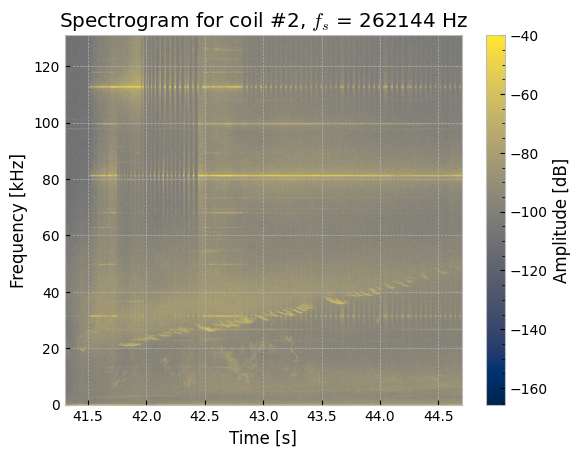

In [10]:
# Setup figures

# This property is related to the Heisenberg uncertainty principle, but not directly – see Gabor limit for discussion.
# The product of the standard deviation in time and frequency is limited. The boundary of the uncertainty principle 
# (best simultaneous resolution of both) is reached with a Gaussian window function (or mask function), as the Gaussian
#  minimizes the Fourier uncertainty principle. This is called the Gabor transform (and with modifications for multiresolution 
# becomes the Morlet wavelet transform).

fig, ax1 = plt.subplots()

Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=fs, noverlap=int(NFFT/2), cmap='cividis',
interpolation = None, xextent = (time[0], time[-1]) )
# This uses STFT: Short-Time Fourier Transform.

# Debugging:
print(Pxx.shape, freqs.shape, bins.shape)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.title(r'Spectrogram for coil #2, $f_{s}$' + f' = {fs:.0f} Hz')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]')

scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

# plt.axis((41.5, 44.5, 0, 120e3)) # Chosen interval!
# plt.savefig('Coil2_Spectrogram.svg', format = 'svg')
plt.show()

['aaaa', 'aaad', 'aadd', 'aada', 'adda', 'addd', 'adad', 'adaa', 'ddaa', 'ddad', 'dddd', 'ddda', 'dada', 'dadd', 'daad', 'daaa'] [[0.007926   0.00754402 0.00741844 ... 0.01635147 0.00606078 0.03065917]
 [0.00146717 0.00342989 0.00054767 ... 0.01667515 0.00938865 0.01220388]
 [0.00331762 0.00440063 0.00912503 ... 0.01491946 0.02363626 0.02159926]
 ...
 [0.00173402 0.00128436 0.00036365 ... 0.01855901 0.05534472 0.05078413]
 [0.00105073 0.00110138 0.00021145 ... 0.00878595 0.00095772 0.00419682]
 [0.0033046  0.00207776 0.00225881 ... 0.00640373 0.00732243 0.01676062]]


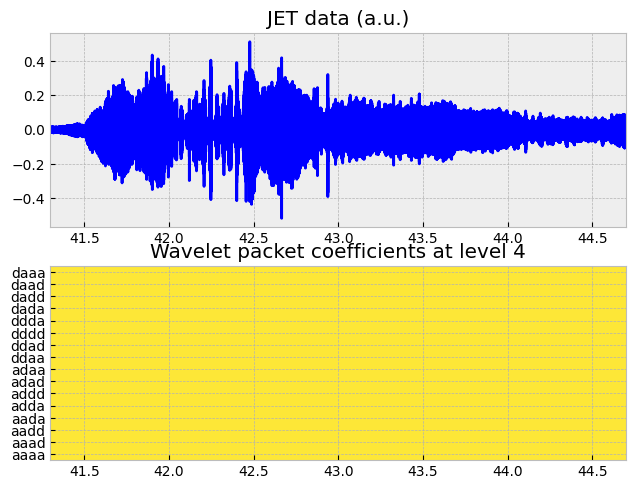

In [9]:
import matplotlib.cm as cm
import pylab

import pywt

wavelet = 'db2'
level = 4
order = "freq"  # "normal"
interpolation = 'nearest'

t= time

wp = pywt.WaveletPacket(data, wavelet, 'sym', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = pylab.array([n.data for n in nodes], 'd')
values = abs(values)
print(labels, values)

f = pylab.figure()
f.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
pylab.subplot(2, 1, 1)
pylab.title("JET data (a.u.)")
pylab.plot(t, data, 'b')
pylab.xlim(t[0], t[-1])

ax = pylab.subplot(2, 1, 2)
pylab.title("Wavelet packet coefficients at level %d" % level)
pylab.imshow(values, interpolation=interpolation, cmap='cividis', aspect="auto",
    origin="lower", extent = [t[0], t[-1], 0, len(values)],
    vmax=power.max(), vmin=power.min())
pylab.yticks(pylab.arange(0.5, len(labels) + 0.5), labels)
# pylab.setp(ax.get_xticklabels(), visible=False)

pylab.show()

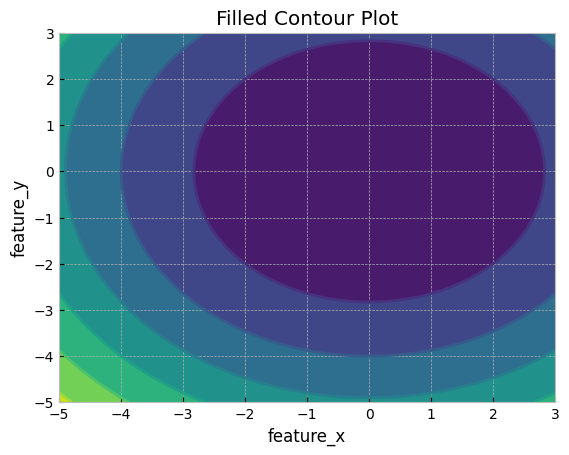

In [32]:

# Implementation of matplotlib function
import matplotlib.pyplot as plt
import numpy as np
  
feature_x = np.linspace(-5.0, 3.0, 70)
feature_y = np.linspace(-5.0, 3.0, 70)
  
# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)
  
fig, ax = plt.subplots(1, 1)
  
Z = X ** 2 + Y ** 2
  
# plots filled contour plot
ax.contourf(X, Y, Z)
ax.contour(X, Y, Z)
  
ax.set_title('Filled Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
  
plt.show()

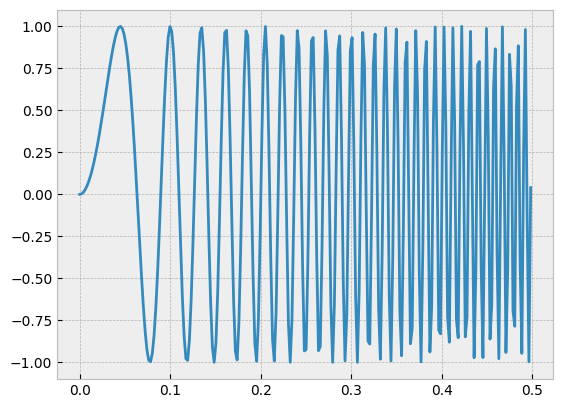

In [2]:
import pylab

x = pylab.arange(0, 0.5, 1. / 512)
data = pylab.sin((5 * 50 * pylab.pi * x ** 2))
plt.plot(x,data)

(17, 15) (17,) (15,)


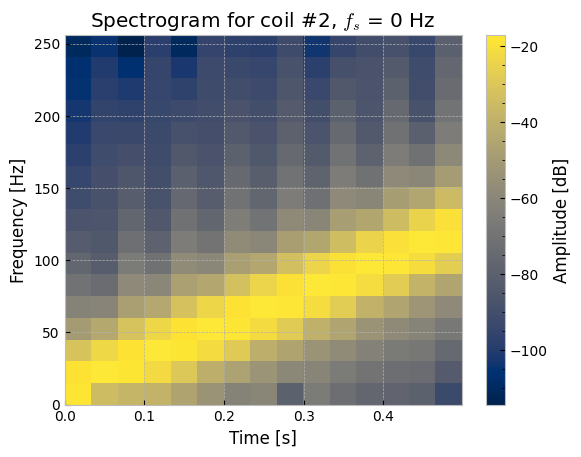

In [3]:
# Setup figures

# This property is related to the Heisenberg uncertainty principle, but not directly – see Gabor limit for discussion.
# The product of the standard deviation in time and frequency is limited. The boundary of the uncertainty principle 
# (best simultaneous resolution of both) is reached with a Gaussian window function (or mask function), as the Gaussian
#  minimizes the Fourier uncertainty principle. This is called the Gabor transform (and with modifications for multiresolution 
# becomes the Morlet wavelet transform).

fig, ax1 = plt.subplots()

Pxx, freqs, bins, im = plt.specgram(data, NFFT=32, Fs=512, noverlap=int(32/2), cmap='cividis',
interpolation = None, xextent = (x[0], x[-1]) )
# This uses STFT: Short-Time Fourier Transform.

# Debugging:
print(Pxx.shape, freqs.shape, bins.shape)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.title(r'Spectrogram for coil #2, $f_{s}$' + f' = {0:.0f} Hz')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

# plt.axis((41.5, 44.5, 0, 120e3)) # Chosen interval!
# plt.savefig('Coil2_Spectrogram.svg', format = 'svg')
plt.show()

Widths = [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29].
0.001953125
[208.         195.76470588 184.88888889 175.15789474 166.4
 158.47619048 151.27272727 144.69565217 138.66666667 133.12
 128.         123.25925926 118.85714286 114.75862069 110.93333333
 107.35483871 104.         100.84848485  97.88235294  95.08571429
  92.44444444  89.94594595  87.57894737  85.33333333  83.2
  81.17073171  79.23809524  77.39534884  75.63636364  73.95555556
  72.34782609  70.80851064  69.33333333  67.91836735  66.56
  65.25490196  64.          62.79245283  61.62962963  60.50909091
  59.42857143  58.38596491  57.37931034  56.40677966  55.46666667
  54.55737705  53.67741935  52.82539683  52.          51.2
  50.42424242  49.67164179  48.94117647  48.23188406  47.54285714
  46.87323944  46.22222222  45.5890411   44.97297297  44.37333333
  43.78947368  43.22077922  42.66666667  42.12658228  41.6
  41.08641975  40.58536585  40.09638554  39.61904762  39.15294118
  38.69

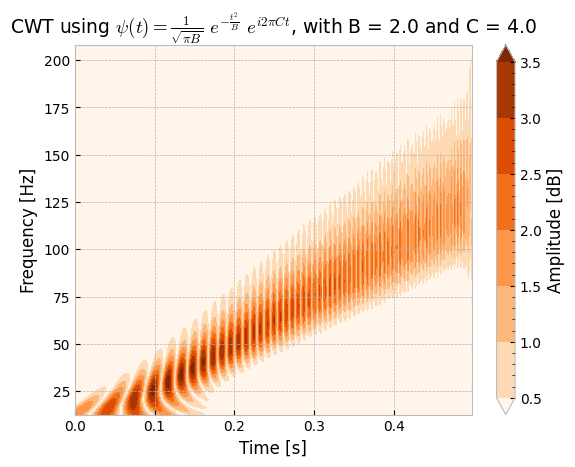

In [13]:
x = pylab.arange(0, 0.5, 1. / 512)
data = pylab.sin((5 * 50 * pylab.pi * x ** 2))

t = x
sig  = data

widths = []
for i in range(1,10):
    widths.append(2**i)
widths = np.arange(2,30)
print(f'Widths = {widths}.')

n = len(sig)
scale_list = np.arange(start=8, stop=n) / 8 + 1 

sampling_period = t[1] - t[0]
print(sampling_period)

cwtmatr, freqs = pywt.cwt(sig, scale_list, 'morl', sampling_period)
print(freqs)
# power = (abs(cwtmatr)) **2
power = abs(cwtmatr) 

# result = np.where(power > 0.0000000001, power, -10)
# power = 10*np.log10(result, out=result, where=result > 0)

# im = plt.imshow(power, cmap='cividis', aspect='auto',
#                 vmax=power.max(), vmin=power.min(),
#                 extent = [t[0], t[-1], freqs[-1], freqs[1]], interpolation = None, resample=False)

# plt.gca().invert_yaxis()

# plt.scatter(x[1:], 250*np.exp(-np.pi*x)[1:])

im = plt.contourf(x, freqs, power, extend='both',cmap='Oranges',
vmax=power.max(), vmin=power.min(),
extent = [t[0], t[-1], freqs[-1], freqs[1]],
                  origin = 'lower')

# im = plt.matshow(power)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.title(r'CWT using $\psi(t) = \frac{1}{\sqrt{\pi B}}$ $e^{-\frac{t^2}{B}}$ $e^{i2\pi Ct}$, with B = 2.0 and C = 4.0', fontsize=13.5)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.show() # This is sort of similar to what we got before (using the STFT)!

In [22]:
very_light_gray = "#efefef"
light_gray = "#999999"
dark_gray = "#444444"
orange = "#EF6C00"
teal = "#007b96"

def _style_axis2d(ax, xlabel: str, ylabel: str):
    """Styles a 2D graph.
    """
    ax.set_xlabel(xlabel, {"color": dark_gray})
    ax.set_ylabel(ylabel, {"color": dark_gray})
    ax.set_title(ax.get_title(), {"color": dark_gray})
    ax.tick_params(axis="x", colors=light_gray)
    ax.tick_params(axis="y", colors=light_gray)
    ax.set_facecolor(very_light_gray)
    for spine in ax.spines.values():
        spine.set_edgecolor(light_gray)


In [29]:
n = len(sig)

print(n)

512


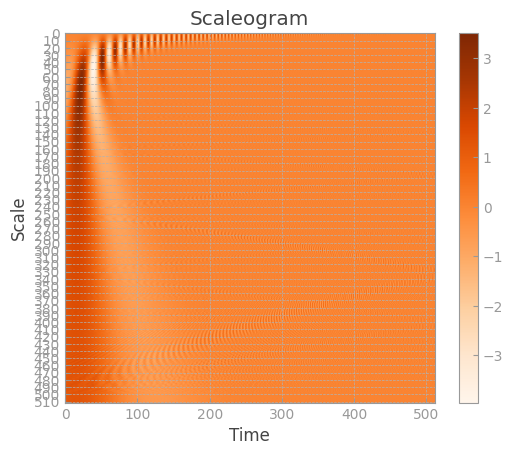

In [30]:
ax = plt.axes()
n = len(sig)

scale_list = np.arange(start=0, stop=n) / 8 + 1 
gram = pywt.cwt(sig, scale_list, 'mexh', sampling_period)[0]

n = gram.shape[0]

plt.imshow(gram, cmap="Oranges")
# We'll show a tick every 10 values.
ticks = np.arange(stop=n, step=10)
labels = np.arange(stop=n, step=10)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
ax.set_title("Scaleogram")
_style_axis2d(ax, "Time", "Scale")
cb = plt.colorbar()
cb.outline.set_color(light_gray)
cb.ax.tick_params(axis="y", colors=light_gray)

plt.show()

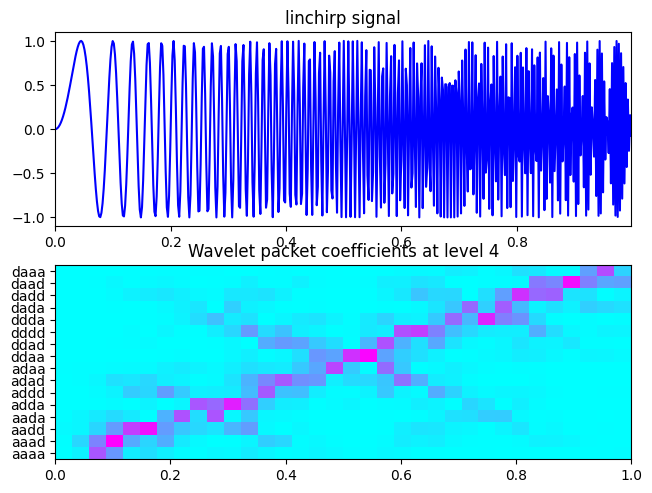

In [ ]:
import matplotlib.cm as cm
import pylab

import pywt

x = pylab.arange(0, 1, 1. / 512)
data = pylab.sin((5 * 50 * pylab.pi * x ** 2))

wavelet = 'db2'
level = 4
order = "freq"  # "normal"
interpolation = 'nearest'
cmap = cm.cool

wp = pywt.WaveletPacket(data, wavelet, 'sym', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = pylab.array([n.data for n in nodes], 'd')
values = abs(values)

f = pylab.figure()
f.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
pylab.subplot(2, 1, 1)
pylab.title("linchirp signal")
pylab.plot(x, data, 'b')
pylab.xlim(0, x[-1])

ax = pylab.subplot(2, 1, 2)
pylab.title("Wavelet packet coefficients at level %d" % level)
pylab.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
    origin="lower", extent=[0, 1, 0, len(values)])
pylab.yticks(pylab.arange(0.5, len(labels) + 0.5), labels)
#pylab.setp(ax.get_xticklabels(), visible=False)

#pylab.figure(2)
#pylab.specgram(data, NFFT=64, noverlap=32, cmap=cmap)
#pylab.imshow(values, origin='upper', extent=[-1,1,-1,1],
# interpolation='nearest')

pylab.show()

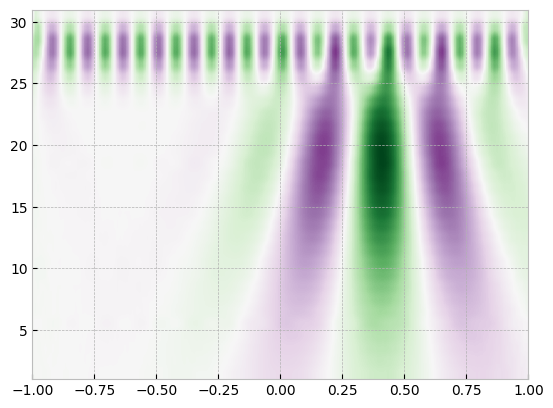

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.
pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()


(9, 24) (9,) (24,)


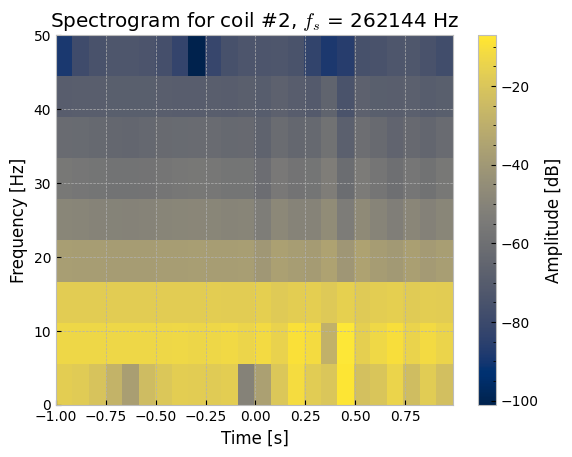

In [ ]:
x = t
data=sig


fig, ax1 = plt.subplots()

Pxx, freqs, bins, im = plt.specgram(data, NFFT=16, Fs=100, noverlap=int(16/2), cmap='cividis',
interpolation = None, xextent = (x[0], x[-1]) )
# This uses STFT: Short-Time Fourier Transform.

# Debugging:
print(Pxx.shape, freqs.shape, bins.shape)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()
plt.title(r'Spectrogram for coil #2, $f_{s}$' + f' = {fs:.0f} Hz')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

# plt.axis((41.5, 44.5, 0, 120e3)) # Chosen interval!
# plt.savefig('Coil2_Spectrogram.svg', format = 'svg')
plt.show()

Widths = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512].
0.010000000000000009
[5.0000000e+01 2.5000000e+01 1.2500000e+01 6.2500000e+00 3.1250000e+00
 1.5625000e+00 7.8125000e-01 3.9062500e-01 1.9531250e-01 9.7656250e-02
 4.8828125e-02]


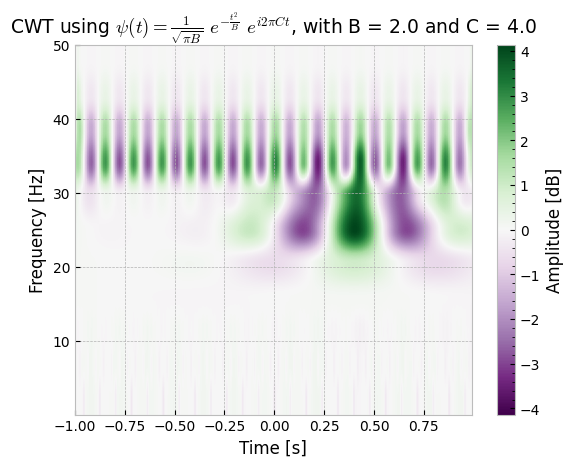

In [ ]:
widths = []
for i in range(-1,10):
    widths.append(2**i)
# widths = np.arange(2, 50) # Just testing stuff.
print(f'Widths = {widths}.')

sampling_period = t[1] - t[0]
print(sampling_period)

cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh', sampling_period)
print(freqs)
power = cwtmatr

result = np.where(power > 0.0000000001, power, -10)
# power = 10*np.log10(result, out=result, where=result > 0)

im = plt.imshow(power, cmap='PRGn', aspect='auto',
                vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max(),
                extent = [t[0], t[-1], freqs[-1], freqs[0]], interpolation = None)

cbar = plt.colorbar(im, label = r'Amplitude [dB]') # Power spectral density amplitude!
cbar.minorticks_on()

plt.title(r'CWT using $\psi(t) = \frac{1}{\sqrt{\pi B}}$ $e^{-\frac{t^2}{B}}$ $e^{i2\pi Ct}$, with B = 2.0 and C = 4.0', fontsize=13.5)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.show() # This is sort of similar to what we got before (using the STFT)!